<p style='text-align:center'>
PSY 394U <b>Methods for fMRI</b>, Fall 2019


<img style='width: 300px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2019/blob/master/Images/Placebo_Left.png?raw=true' alt='brain blobs'/>

</p>

<p style='text-align:center; font-size:40px; margin-bottom: 30px;'><b> Normalization </b></p>

<p style='text-align:center; font-size:18px; margin-bottom: 32px;'><b> September 30, 2019 </b></p>

<hr style='height:5px;border:none' />

# Skull stripping
<hr style="height:1px;border:none" />

## Nipype script
As you can imagine from the name, skull stripping refers to a process of removing non-brain tissues (skulls, bones, soft tissues) from structural MRI data. This step is necessary for normalization in some software packages (such as FSL). Here is an example code to perform skull stripping in FSL.

[`<SkullStrip.py>`](https://github.com/sathayas/fMRIClassFall2019/blob/master/Norm/SkullStrip.py)

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nilearn.plotting import plot_anat, plot_epi, view_img
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from bids.layout import BIDSLayout  # BIDSLayout object to specify file(s)


# Directory where your data set resides.
dataDir = '/tmp/Data/ds102'

# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

# T1 image from the layout object
imageT1 = layout.get(subject='26',
                       suffix='T1w',
                       extension='nii.gz',
                       return_type='file')[0]

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


We shall use the ds102 data set for this example. In particular, subject 26.

Here, we also specify the template image, the image defining the standard space. we use the MNI (Montreal Neurological Institute) template based on 152 subjects (a.k.a., MNI152).

In [2]:
# template image (from FSL)
fMNI = '/usr/local/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'

And I specify the output directory here, under the **`WorkflowOutput`** directory under the data directory.

In [3]:
# Output directory
outDir = os.path.join(dataDir, 'WorkflowOutput')

Now, we can finally define a node for skull striping. we use **BET** (brain extraction tool) from  FSL.

In [4]:
# Skullstrip process node
fslBET = Node(fsl.BET(in_file=imageT1), 
              name="fslBET")

Notice that, since we know the input T1 image, we use it as a parameter when we define the `fslBET` node. 

We are then creating a datasink node to collect the output.

In [5]:
# DataSink to collect intermediate outputs
datasink = Node(DataSink(base_directory=outDir), 
                name='datasink')

At this point we connect the `fslBET` node to the `datasink` node in a workflow.

In [6]:
# Creating a workflow object
wf = Workflow(name="wf", base_dir=outDir)

# connecting nodes as a workflow
wf.connect(fslBET, "out_file", datasink, "deskulled")

We assign an arbitrary output subdirectory name of **`deskulled`**. We are ready to run the workflow now.

In [7]:
# running the workflow
wf.run()

190725-20:02:34,163 nipype.workflow INFO:
	 Workflow wf settings: ['check', 'execution', 'logging', 'monitoring']
190725-20:02:34,173 nipype.workflow INFO:
	 Running serially.
190725-20:02:34,175 nipype.workflow INFO:
	 [Node] Setting-up "wf.fslBET" in "/tmp/Data/ds102/WorkflowOutput/wf/fslBET".
190725-20:02:34,183 nipype.workflow INFO:
	 [Node] Running "fslBET" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /tmp/Data/ds102/sub-26/anat/sub-26_T1w.nii.gz /tmp/Data/ds102/WorkflowOutput/wf/fslBET/sub-26_T1w_brain.nii.gz
190725-20:02:37,433 nipype.workflow INFO:
	 [Node] Finished "wf.fslBET".
190725-20:02:37,435 nipype.workflow INFO:
	 [Node] Setting-up "wf.datasink" in "/tmp/Data/ds102/WorkflowOutput/wf/datasink".
190725-20:02:37,442 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
190725-20:02:37,474 nipype.workflow INFO:
	 [Node] Finished "wf.datasink".


## Results

Let's see the results from skull stripping. The skull-stripped image is located under `WorkflowOutput/deskulled` directory. The file name `sub-26_T1w_brain.nii.gz` is derived from the original image file name `sub-26_T1w.nii.gz` with the suffix `_brain` (i.e., no skull).

In [12]:
%matplotlib inline

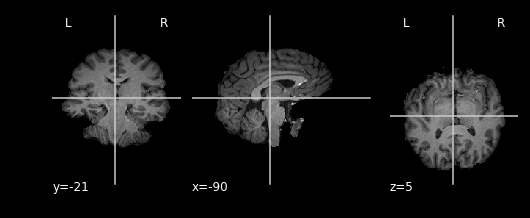

In [13]:
# Skull-stripped image
imageT1BET = os.path.join(os.path.join(outDir,'deskulled'),
                          'sub-26_T1w_brain.nii.gz')

# displaying image
plot_anat(imageT1BET,
          display_mode='ortho',
          dim=-1,
          draw_cross=True,
          annotate=True)


As you see, there is no skull anymore. Just for fun, here is an interactive image viewer.

In [14]:
# interactive visualization
view_img(imageT1BET, bg_img=False, cmap='gray', symmetric_cmap=False,
         black_bg=True)

# Co-registration
<hr style="height:1px;border:none" />

## What is co-registration?
It is highly likely that your fMRI data initially are not in the same orientation as the accompanying T1-weighted image. The **co-registration** process re-orient your fMRI data in the same orientation as the T1-weighted image. Doing so facilitates normalization of fMRI data, as we see later. 

Co-registration of fMRI data to T1 image data is often done with rigid-body transformation, similar to motion correction. This is because we only need to correct the orientation of fMRI data, but not the shape of fMRI data.



## Co-registration in Nipype
Co-registration in FSL can be accomplished by **FLIRT** in FSL. But we have to run FLIRT twice: the first FLIRT estimates co-registration parameters, and the second FLIRT applies normalization parameters to all time points. Here in the example code below, we are appending the co-registration to the motion-correction workflow we saw in the previous class. 

[`<CoReg.py>`](https://github.com/sathayas/fMRIClassFall2019/blob/master/Norm/CoReg.py)

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nilearn import image
from nilearn.plotting import plot_anat, plot_epi, view_img
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from bids.layout import BIDSLayout  # BIDSLayout object to specify file(s)


# Directory where your data set resides.
dataDir = '/tmp/Data/ds102'

# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

# an fMRI image from one of the subjects (run 1 only)
imagefMRI = layout.get(subject='26',
                       run='1',
                       suffix='bold',
                       extension='nii.gz',
                       return_type='file')[0]

# T1 image from the layout object
imageT1 = layout.get(subject='26',
                       suffix='T1w',
                       extension='nii.gz',
                       return_type='file')[0]

# Output directory
outDir = os.path.join(dataDir, 'WorkflowOutput')

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Again, we are using Subject 26 Run 1 from the flanker task data (a.k.a., ds102).

Now, let's define nodes to skip dummy scans and motion correction.

In [2]:
# node to skip dummy scans
extract = Node(fsl.ExtractROI(in_file=imagefMRI,  # input image
                              t_min=4,            # first 4 volumes are deleted
                              t_size=-1),
               name="extract")

Here, MCFLIRT is slightly different. We are using the mean fMRI time series as the reference. This forces MCFLIRT to produce a mean image as the output (to be used later).

In [3]:
# creating motion correction node
mcflirt = Node(fsl.MCFLIRT(save_rms=True,
                           save_plots=True,
                           mean_vol=True),   # saving displacement parameters
               name="mcflirt")

Now, the first FLIRT node, referred as **`coreg`**. This FLIRT node estimates a rigid-body transformation (i.e., rotations and translations) necessary to match the functional image to the T1-weighted image in the native space.

In [4]:
# creating co-registration node (estimating the coregistration parameters)
coreg = Node(fsl.FLIRT(reference=imageT1,  # target: T1-weighted
                       dof=6,       # specifying rigid-body (6-parameters)
                       cost='normmi'), # normizied mutual info
             name="coreg")

One thing to note here is that we are using **`cost='normmi'`**, or the cost function is normalized mutual information. Since the structural image (T1-weighted) and the functional image (T2*-weighted) have different contrasts, it makes sense to use an information theory-based cost function. It is based on the joint distribution of both modalities, as opposed to the similarity in intensities in both modalities. 

The parameter **`dof=6`** indicates that we are applying a rigid-body transformation.

The second FLIRT node, referred as **`applywarp`**. This node applies the rigid-body transformation estimated from the previous FLIRT node and transform all the time points in the fMRI time series.

In [5]:
# applying the coregistration parameters to the entire time series
applywarp = Node(fsl.FLIRT(reference=imageT1,
                           apply_isoxfm=4),  # forcing the voxel size = 4mm
                 name="applywarp")

Here we have to use the T1 image as the reference image, since the parameters estimated from the first FLIRT is the transformation to T1. We also specify **`apply_isoxfm=4`**. This means the output image is generated by isotropic sampling (i.e., voxel size with the same width, depth, and height) specifying that the voxel size is 4 x 4 x 4 mm.

Let's create a data sink and a workflow object.

In [6]:
# creating datasink to collect outputs
datasink = Node(DataSink(base_directory=outDir), 
                name='datasink')

# creating a workflow
coReg = Workflow(name="coReg", base_dir=outDir)

And connecting nodes.

In [7]:
# and connecting nodes
coReg.connect(extract,'roi_file', mcflirt, 'in_file')
# mcflirt mean image as input for the first FLIRT
coReg.connect(mcflirt, 'mean_img', coreg, 'in_file')  
# mcflirt fMRI as input for the second FLIRT
coReg.connect(mcflirt, 'out_file', applywarp, 'in_file') 
# and passing on the rigid-body transformation parameters from first FLIRT
coReg.connect(coreg, 'out_matrix_file', applywarp,'in_matrix_file')

# second FLIRT node to data sink
coReg.connect(applywarp, 'out_file', datasink, 'CoRegfMRI')
# second motion corredted mean fMRI to data sink
coReg.connect(mcflirt, 'mean_img', datasink, 'MoCorMean')

Note that the rigid-body transformation parameters from the first FLIRT (**`out_matrix_file`**) is used in the `applywarp` node to apply the transformation to the rest of fMRI time series data.

For fun, let's see the workflow diagram.

In [8]:
%matplotlib inline

190726-20:36:30,83 nipype.workflow INFO:
	 Generated workflow graph: /tmp/Data/ds102/WorkflowOutput/coReg/graph_orig.png (graph2use=orig, simple_form=True).


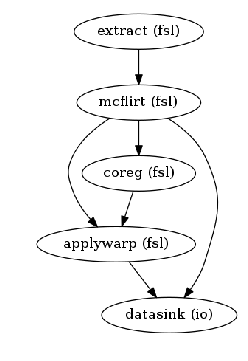

In [9]:
# writing out graph
coReg.write_graph(graph2use='orig', dotfilename='graph_orig.dot')

# showing the graph
plt.figure(figsize=[6,6])
img=mpimg.imread(os.path.join(outDir,"coReg","graph_orig.png"))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Let's run the workflow!

In [10]:
# running the workflow
coReg.run()

190726-20:36:32,607 nipype.workflow INFO:
	 Workflow coReg settings: ['check', 'execution', 'logging', 'monitoring']
190726-20:36:32,621 nipype.workflow INFO:
	 Running serially.
190726-20:36:32,623 nipype.workflow INFO:
	 [Node] Setting-up "coReg.extract" in "/tmp/Data/ds102/WorkflowOutput/coReg/extract".
190726-20:36:32,628 nipype.workflow INFO:
	 [Node] Cached "coReg.extract" - collecting precomputed outputs
190726-20:36:32,630 nipype.workflow INFO:
	 [Node] "coReg.extract" found cached.
190726-20:36:32,632 nipype.workflow INFO:
	 [Node] Setting-up "coReg.mcflirt" in "/tmp/Data/ds102/WorkflowOutput/coReg/mcflirt".
190726-20:36:32,637 nipype.workflow INFO:
	 [Node] Cached "coReg.mcflirt" - collecting precomputed outputs
190726-20:36:32,639 nipype.workflow INFO:
	 [Node] "coReg.mcflirt" found cached.
190726-20:36:32,640 nipype.workflow INFO:
	 [Node] Setting-up "coReg.coreg" in "/tmp/Data/ds102/WorkflowOutput/coReg/coreg".
190726-20:36:32,645 nipype.workflow INFO:
	 [Node] Cached "coR

## Results

Let's examine the co-registration results. First, we calculate the mean image from the co-registered fMRI data (so that it is 3D data). 

In [23]:
# examining the coregistration results
# Coregistered fMRI
imageCoRegfMRI = os.path.join(os.path.join(outDir,'CoRegfMRI'),
                              'sub-26_task-flanker_run-1_bold_roi_mcf_flirt.nii.gz')
# mean of the co-registered fMRI
mean_imageCoRegfMRI = image.mean_img(imageCoRegfMRI)

Here, we use the **`mean_img`** function from the **`nilearn.image`** library. The resulting mean image is displayed, with the outline from the corresponding structural image added.

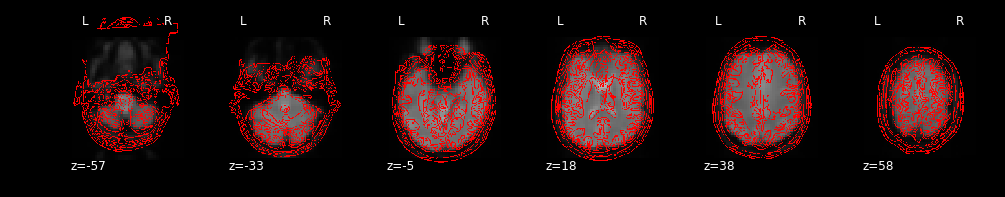

In [41]:
# displaying the mean of the co-registered fMRI (axial)
display = plot_anat(mean_imageCoRegfMRI,
                    display_mode='z',
                    cut_coords=6)

# adding edges from the corresponding T1w image
display.add_edges(imageT1)

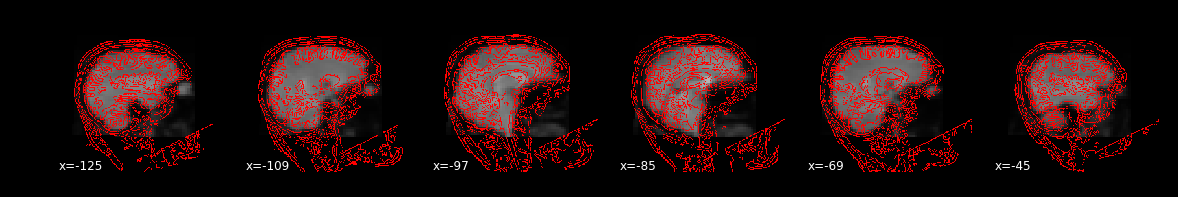

In [42]:
# displaying the mean of the co-registered fMRI (sagittal)
display = plot_anat(mean_imageCoRegfMRI,
                    display_mode='x',
                    cut_coords=6)

# adding edges from the corresponding T1w image
display.add_edges(imageT1)

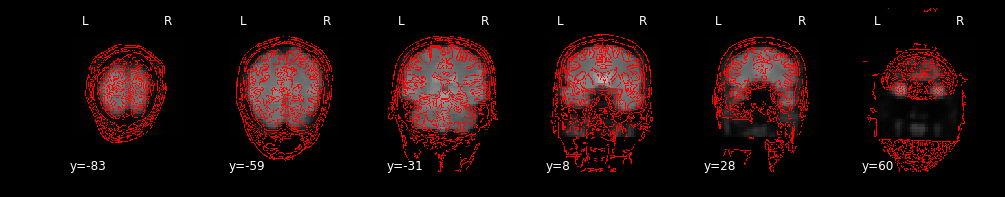

In [44]:
# displaying the mean of the co-registered fMRI (coronal)
display = plot_anat(mean_imageCoRegfMRI,
                    display_mode='y',
                    cut_coords=6)

# adding edges from the corresponding T1w image
display.add_edges(imageT1)

Just for your information, if we didn't do co-registration, this is how much fMRI and T1 images are different.

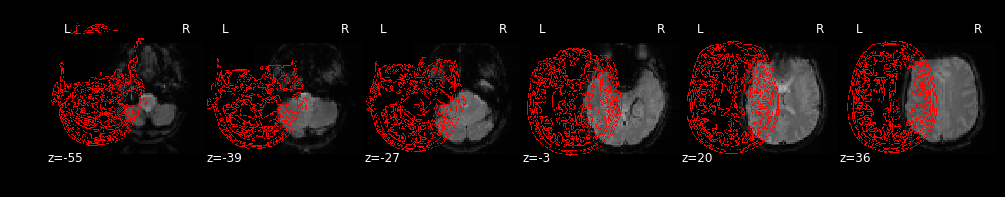

In [12]:
# Just for fun; original fMRI and T1 -- how different they are
# mean fMRI from motion corrected
imageMoCorfMRI = os.path.join(os.path.join(outDir,'MoCorMean'),
                              'sub-26_task-flanker_run-1_bold_roi_mcf.nii.gz_mean_reg.nii.gz')
# displaying the mean of the co-registered fMRI (axial)
display = plot_anat(imageMoCorfMRI,
                    display_mode='z',
                    cut_coords=6)

# adding edges from the corresponding T1w image
display.add_edges(imageT1)


# Normalization of T1 image
<hr style="height:1px;border:none" />

Normalization means warping someone's brain imaging data into the standard-shape brain (a.k.a., template). This steps is usually done by first normalizing a T1 weighted image from a subject's **native space** to the template space. The resulting warp parameters (from the native space to the template space) are then applied to the accompanying fMRI data (co-registered to the T1 image space). Here in this section, we outline how to normalize a T1-weighted image from the native space to the template space.

## Normalization with Nipype
Normalization of a T1-image requires 3 steps: skull-stripping, linear normalization, and non-linear normalization.

[`<Norm.py>`](https://github.com/sathayas/fMRIClassFall2019/blob/master/Norm/Norm.py)

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from bids.layout import BIDSLayout  # BIDSLayout object to specify file(s)
from nilearn import image
from nilearn.plotting import plot_anat, view_img


# Directory where your data set resides.
dataDir = '/tmp/Data/ds102'

# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

# an T1 weighted image from one of the subjects
imageT1 = layout.get(subject='26',
                     suffix='T1w',
                     extension='nii.gz',
                     return_type='file')[0]

# template image (from FSL)
fMNI = '/usr/share/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'

# Output directory
outDir = os.path.join(dataDir, 'WorkflowOutput')

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Here, I am defining 
  * the data directory **`dataDir`**
  * the T1-weighted image to be used (**`imageT1`**) 
  * the template image defining the template space (**`fMNI`**, FSL's template for the MNI space)
  * the output directory **`outDir`**

The location of these files / directories may need to be altered, depending on the computer you are using.

In [2]:
# Skullstrip process node
fslBET = Node(fsl.BET(in_file=imageT1), 
              name="fslBET")

Here is the first node. The **`Node`** object is defined in **`nipype`** library. It takes a process (in this case **`fsl.BET`**) along with some parameters. In this case, the input file **`in_file`** is the only parameter to be used. I name this node **`fslBET`**. Now let's define the linear and non-linear normalization nodes as well.

In [3]:
# Linear normalization node
fslFLIRT = Node(fsl.FLIRT(reference=fMNI,
                          cost_func='normmi'),
                name="fslFLIRT")

# Non-linear normalization node
fslFNIRT = Node(fsl.FNIRT(ref_file=fMNI),
                name='fslFNIRT')

For the linear normalization process, I use **`fsl.FLIRT`**. For the non-linear normalization process, I use **`fsl.FNIRT`**. I name them `fslFLIRT` and `fslFNIRT`, respectively. Both processes require **`reference`**, the template image, as the input parameter. In addition, for `fslFLIRT`, I specify the cost function **`cost_func`** parameter as **`'normmi'`** or normalized mutual information.

And we create a datasink node to collect output.

In [4]:
# DataSink to collect intermediate outputs
datasink = Node(DataSink(base_directory=outDir),
                name='datasink')

Now all the nodes are defined. Let's create a workflow.

In [5]:
# Creating a workflow object
wfNormT1 = Workflow(name="wfNormT1", base_dir=outDir)

And connect nodes.

In [6]:
# connecting nodes as a workflow
wfNormT1.connect(fslBET, "out_file", fslFLIRT, "in_file")
wfNormT1.connect(fslBET, 'out_file', fslFNIRT,'in_file')

Here, `fslBET` is connected to `fslFLIRT` and `fslFNIRT`. The output from `fslBET`, **`out_file`**, is used as the input to `fslFLIRT` and `fslFNIRT`, **`in_file`**. 

We also pass on the linear normalization matrix `out_matrix_file` as the input parameter `affile_file` in the `fslFNIRT` node.

In [7]:
wfNormT1.connect(fslFLIRT, 'out_matrix_file', fslFNIRT, 'affine_file')

We also collect the output into the datasink. 

In [8]:
# adding datasink
wfNormT1.connect(fslFLIRT, 'out_file', datasink, 'NormLinear')
wfNormT1.connect(fslFNIRT, 'warped_file', datasink, 'NormNonLinear')

Linear and non-linear normalized T1 images are written to `NormLinear` and `NormNonLinear` directories, respectively.

We can now visualize the workflow.

In [9]:
%matplotlib inline

190814-23:08:14,409 nipype.workflow INFO:
	 Generated workflow graph: /tmp/Data/ds102/WorkflowOutput/wfNormT1/graph_orig.png (graph2use=orig, simple_form=True).


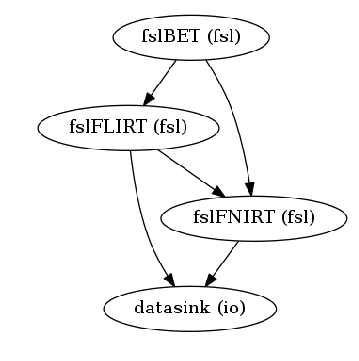

In [10]:
# writing out graphs
wfNormT1.write_graph(graph2use='orig', dotfilename='graph_orig.dot')

# showing the graph
plt.figure(figsize=[6,6])
img=mpimg.imread(os.path.join(outDir,"wfNormT1","graph_orig.png"))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()


OK, now we run the workflow. ***NB: this may take 5-10 minutes.***

In [11]:
# running the workflow
wfNormT1.run()

190814-23:08:18,751 nipype.workflow INFO:
	 Workflow wfNormT1 settings: ['check', 'execution', 'logging', 'monitoring']
190814-23:08:18,777 nipype.workflow INFO:
	 Running serially.
190814-23:08:18,780 nipype.workflow INFO:
	 [Node] Setting-up "wfNormT1.fslBET" in "/tmp/Data/ds102/WorkflowOutput/wfNormT1/fslBET".
190814-23:08:18,798 nipype.workflow INFO:
	 [Node] Running "fslBET" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /tmp/Data/ds102/sub-26/anat/sub-26_T1w.nii.gz /tmp/Data/ds102/WorkflowOutput/wfNormT1/fslBET/sub-26_T1w_brain.nii.gz
190814-23:08:23,79 nipype.workflow INFO:
	 [Node] Finished "wfNormT1.fslBET".
190814-23:08:23,85 nipype.workflow INFO:
	 [Node] Setting-up "wfNormT1.fslFLIRT" in "/tmp/Data/ds102/WorkflowOutput/wfNormT1/fslFLIRT".
190814-23:08:23,112 nipype.workflow INFO:
	 [Node] Running "fslFLIRT" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /tmp/Data/ds102/WorkflowOutput/wfNormT1/

## Examining resulting images

Now, let's take a look at the normalized T1 image. First, the results from linear normalization only. Starting from axial sections. The background image is the template. The outlines are from the normalized T1 image.

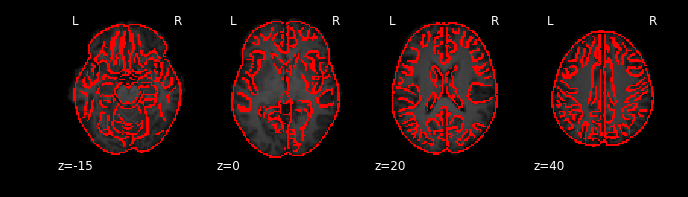

In [12]:
# examining the normalization results
# Linear normalized T1
imageNormLinT1 = os.path.join(os.path.join(outDir,'NormLinear'),
                              'sub-26_T1w_brain_flirt.nii.gz')

# displaying the normalized T1 (axial)
display = plot_anat(imageNormLinT1,
                    display_mode='z',
                    cut_coords=[-15,0,20,40])

# adding edges from the MNI template image
display.add_edges(fMNI)

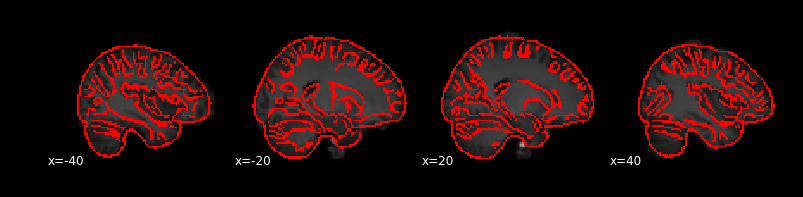

In [13]:
# displaying the normalized T1 (sagittal)
display = plot_anat(imageNormLinT1,
                    display_mode='x',
                    cut_coords=[-40,-20,20,40])

# adding edges from the MNI template image
display.add_edges(fMNI)

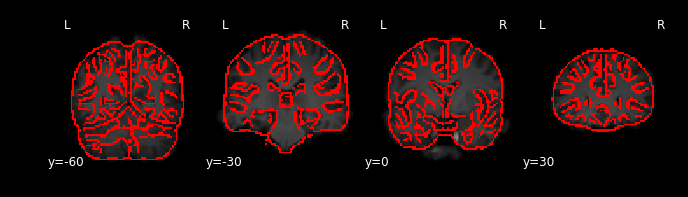

In [14]:
# displaying the normalized T1 (coronal)
display = plot_anat(imageNormLinT1,
                    display_mode='y',
                    cut_coords=[-60,-30,0,30])

# adding edges from the MNI template image
display.add_edges(fMNI)

As you can see, the brain seems to fit inside the outline (MNI template), just with linear normalization alone. Now we see the results with linear and non-linear normalization combined.

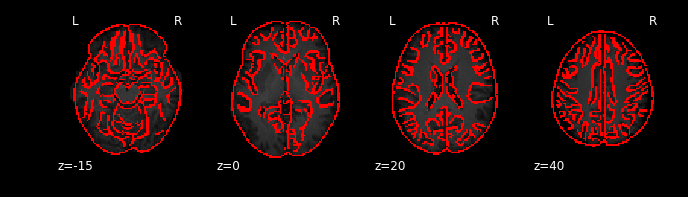

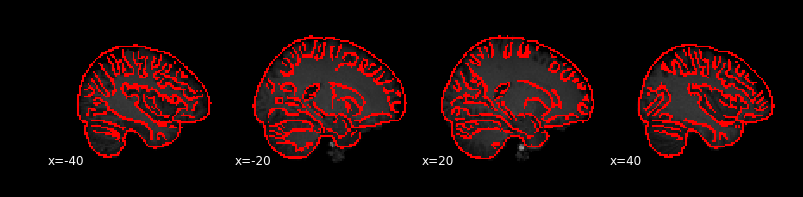

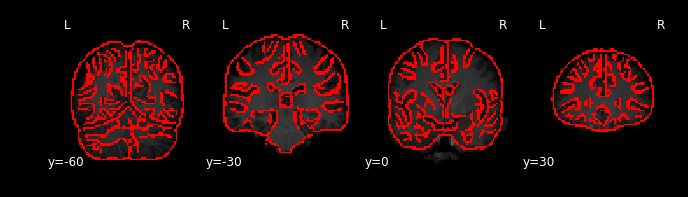

In [15]:
# examining the normalization results
# Linear & non-linear normalized T1
imageNormNonLinT1 = os.path.join(os.path.join(outDir,'NormNonLinear'),
                                 'sub-26_T1w_brain_warped.nii.gz')

# displaying the normalized T1 (axial)
display = plot_anat(imageNormNonLinT1,
                    display_mode='z',
                    cut_coords=[-15,0,20,40])

# adding edges from the MNI template image
display.add_edges(fMNI)

# displaying the normalized T1 (sagittal)
display = plot_anat(imageNormNonLinT1,
                    display_mode='x',
                    cut_coords=[-40,-20,20,40])

# adding edges from the MNI template image
display.add_edges(fMNI)

# displaying the normalized T1 (coronal)
display = plot_anat(imageNormNonLinT1,
                    display_mode='y',
                    cut_coords=[-60,-30,0,30])

# adding edges from the MNI template image
display.add_edges(fMNI)

If you look carefully, the ventricles seem to line up better with linear + non-linear normalization. On the other hand, the edge of the brain does not seem to line up with the template near the top.

## Quality of normalization
There isn't quantitative metric to quantify the quality of normalization. The quality of normalization is typically examined by humans. This is done by comparing the outlines of the normalized brain to the outline of the template brain. Also, some major anatomical landmarks may be compared (e.g., particular gyri, sulci, etc.).

If the quality of normalization is deemed sub-optimal, there are several approaches to improve normalization. The following is not an exhaustive list of possible solutions. Rather, somewhat common remedies for improved normalization.

  * Make sure that the native T1-weighted image is close to the template in terms of the location and the orientation.
     * Make a manual adjustment of the placement of the data.
  * Include more (or less) non-brain tissues (see Exercise below)
  * Increase regularization. This is a good solution when you see some extreme warping in the normalized image.
 


### Exercise


1. **Normalization with more stuff**. Construct another normalization workflow with the `fsl.BET` node with the parameter **`frac=0.2`**, so that more brain tissues (as well as non brain tissues) are included in the skull striped brain. Post the code for the `fslBET` node on Canvas. How does this affect the quality of normalization?

2. **Normalization with less stuff**. Construct another normalization workflow with the `fsl.BET` node with the parameter **`frac=0.8`**, so that less brain tissues (as well as non brain tissues) are included in the skull striped brain. Post the code for the `fslBET` node on Canvas. How does this affect the quality of normalization?

